# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [2]:
import os, sys

import popv
import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
import sys
sys.path.insert(-1, '..')
import _utils

From /home/cane/miniconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Created a temporary directory at /tmp/tmpijlv8hnx
Writing /tmp/tmpijlv8hnx/_remote_module_non_scriptable.py
Global seed set to 0


ModuleNotFoundError: No module named '_utils'

## Run PopV

In [2]:
refdata_url = '"https://zenodo.org/record/7587774/files/TS_Lung_filtered.h5ad?download"'
lung_fn = 'data/Lung.h5ad'
if not os.path.exists(lung_fn):
    !wget -O $lung_fn $refdata_url

lung = anndata.read(lung_fn)

In [3]:
lung

AnnData object with n_obs × n_vars = 35672 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [4]:
query_index = np.random.choice([0,1,2,3,4], size = len(lung), replace=True)

In [5]:
if not os.path.exists('data'):
    os.mkdir('data')

In [6]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    lung[query_index!=i].write(ref_adata_path)
    lung[query_index==i].write(query_adata_path)

In [7]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [8]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [9]:
for i in range(0,5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../PopV/ontology/',
        pretrained_scvi_path=None,
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

0


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 126 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 35672 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3874 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98524404 0.04727587 0.00576535 0.00541516 0.00740741
  0.05390602 0.01124243 0.00690608 0.        ]
 [0.         0.         0.14869467 0.01021566 0.0045403  0.
  0.20885358 0.02383655 0.03038674 0.        ]
 [0.         0.         0.         0.9853599  0.49097473 0.3037037
  0.1323901  0.04596679 0.04281768 0.03389831]
 [0.         0.         0.         0.         0.5234657  0.26666667
  0.27084181 0.03660024 0.02900552 0.01129944]
 [0.         0.         0.         0.         0.         1.
  0.24548736 0.0198556  0.4566787  0.15254237]
 [0.         0.         0.         0.         0.         0.
  0.21481481 0.02962963 0.48888889 0.14074074]
 [0.         0.         0.         0.         0.         0.
  0.         0.98606168 0.2140884  0.14124294]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.47651934 0.16949153]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Epoch 112/112: 100%|██████████| 112/112 [04:57<00:00,  4.15s/it, loss=1.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=112` reached.


Epoch 112/112: 100%|██████████| 112/112 [04:57<00:00,  2.65s/it, loss=1.56e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-02-07 17:40:20.065569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:40:20.090292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:40:20.090402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:40:20.090600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executo

Training cost after epoch 1: loss:5.334755 acc: 0.959 auc: 1.000 auprc: 0.976
Training cost after epoch 2: loss:2.478975 acc: 0.986 auc: 1.000 auprc: 0.999
Training cost after epoch 3: loss:1.602566 acc: 0.993 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.164918 acc: 0.996 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.876959 acc: 0.996 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.672198 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.524111 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.416339 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.335401 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.279431 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.237025 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.208900 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.183617 acc: 0.998 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_0/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:42<00:00,  1.73s/it, loss=1.67e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it, loss=1.67e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_0/popv_results_0/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

1


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 116 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 35672 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3884 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.99061033 0.05517439 0.00473747 0.00534759 0.0078125
  0.06003431 0.00743282 0.         0.        ]
 [0.         0.         0.15492958 0.01643192 0.00534759 0.015625
  0.21478873 0.02464789 0.01925722 0.        ]
 [0.         0.         0.         0.98499803 0.40819964 0.3359375
  0.13245417 0.03884346 0.04264099 0.03448276]
 [0.         0.         0.         0.         0.5258467  0.3125
  0.26964074 0.0351362  0.04126547 0.01724138]
 [0.         0.         0.         0.         0.         0.9921875
  0.20499109 0.01960784 0.4786795  0.20114943]
 [0.         0.         0.         0.         0.         0.
  0.2734375  0.0078125  0.4296875  0.0625    ]
 [0.         0.         0.         0.         0.         0.
  0.         0.98831776 0.19394773 0.12643678]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.45667125 0.13218391]
 [0.         0.         0.         0.         0.         0.
  0.         0.  

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/112: 100%|██████████| 112/112 [06:03<00:00,  2.46s/it, loss=1.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=112` reached.


Epoch 112/112: 100%|██████████| 112/112 [06:03<00:00,  3.24s/it, loss=1.53e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-02-07 18:13:26.940627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:13:26.941172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:13:26.941399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:13:26.950203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executo

Training cost after epoch 1: loss:5.419208 acc: 0.957 auc: 1.000 auprc: 0.976
Training cost after epoch 2: loss:2.559261 acc: 0.984 auc: 1.000 auprc: 0.999
Training cost after epoch 3: loss:1.692815 acc: 0.992 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.255052 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.962355 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.747293 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.590435 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.471706 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.382603 acc: 1.000 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.315759 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.265417 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.230949 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.199818 acc: 0.999 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_1/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:36<00:00,  1.78s/it, loss=1.71e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:36<00:00,  1.85s/it, loss=1.71e+03, v_num=1]


Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]
Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_1/popv_results_1/predictions.csv
... storing 'free_annotation' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'cell_type' as categorical
... storing 'cell_ontology_class_tissue' as categorical
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_predictio

2


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 105 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 35672 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3895 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.97652582 0.05460263 0.00762746 0.01077199 0.
  0.06203545 0.01972556 0.00138122 0.        ]
 [0.         0.         0.15258216 0.01056338 0.005386   0.00757576
  0.21126761 0.0399061  0.02900552 0.        ]
 [0.         0.         0.         0.97631473 0.43267504 0.24242424
  0.12901818 0.05179856 0.0441989  0.05084746]
 [0.         0.         0.         0.         0.48833034 0.26515152
  0.26053794 0.03010839 0.02071823 0.01694915]
 [0.         0.         0.         0.         0.         0.96212121
  0.21543986 0.03590664 0.48756906 0.21468927]
 [0.         0.         0.         0.         0.         0.
  0.29545455 0.02272727 0.40151515 0.14393939]
 [0.         0.         0.         0.         0.         0.
  0.         0.9847482  0.21961326 0.10169492]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.46270718 0.15254237]
 [0.         0.         0.         0.         0.         0.
  0.         0. 

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/112: 100%|██████████| 112/112 [05:32<00:00,  2.57s/it, loss=1.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=112` reached.


Epoch 112/112: 100%|██████████| 112/112 [05:32<00:00,  2.97s/it, loss=1.56e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-02-07 18:48:34.681947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:48:34.682109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:48:34.682168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:48:34.682273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executo

Training cost after epoch 1: loss:5.355042 acc: 0.964 auc: 1.000 auprc: 0.978
Training cost after epoch 2: loss:2.518330 acc: 0.985 auc: 1.000 auprc: 0.999
Training cost after epoch 3: loss:1.644527 acc: 0.990 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.206469 acc: 0.995 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.913881 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.703767 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.550546 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.436745 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.353652 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.301430 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.249581 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.213236 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.185571 acc: 0.998 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_2/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  1.65s/it, loss=1.68e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it, loss=1.68e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_2/popv_results_2/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

3


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 100 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 35672 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3900 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98468271 0.05384168 0.00712307 0.00359066 0.00757576
  0.06053551 0.00873108 0.         0.        ]
 [0.         0.         0.15207877 0.01203501 0.00218818 0.
  0.2166302  0.02188184 0.03333333 0.        ]
 [0.         0.         0.         0.98377523 0.47755835 0.27272727
  0.13328019 0.03851765 0.05694444 0.02762431]
 [0.         0.         0.         0.         0.48833034 0.25757576
  0.26276217 0.03165809 0.01666667 0.01104972]
 [0.         0.         0.         0.         0.         0.96969697
  0.27109515 0.005386   0.46499102 0.13812155]
 [0.         0.         0.         0.         0.         0.
  0.27272727 0.00757576 0.54545455 0.18181818]
 [0.         0.         0.         0.         0.         0.
  0.         0.97869857 0.19444444 0.15469613]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.46111111 0.19337017]
 [0.         0.         0.         0.         0.         0.
  0.         0. 

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/112: 100%|██████████| 112/112 [05:08<00:00,  2.80s/it, loss=1.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=112` reached.


Epoch 112/112: 100%|██████████| 112/112 [05:08<00:00,  2.75s/it, loss=1.53e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-02-07 19:17:39.852965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 19:17:39.853418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 19:17:39.853475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 19:17:39.854341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executo

Training cost after epoch 1: loss:5.352820 acc: 0.961 auc: 1.000 auprc: 0.971
Training cost after epoch 2: loss:2.494257 acc: 0.985 auc: 1.000 auprc: 0.999
Training cost after epoch 3: loss:1.608766 acc: 0.993 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.166094 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.874092 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.667092 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.517523 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.408372 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.329708 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.272612 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.232939 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.201590 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.177948 acc: 0.999 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_3/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:53<00:00,  2.37s/it, loss=1.68e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:53<00:00,  2.69s/it, loss=1.68e+03, v_num=1]


Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]
Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_3/popv_results_3/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing '

4


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 115 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 35672 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3885 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.9800235  0.0425836  0.00320384 0.01328273 0.00617284
  0.06030294 0.014004   0.         0.        ]
 [0.         0.         0.1386604  0.01880141 0.00822562 0.01234568
  0.23501763 0.03407756 0.02538787 0.        ]
 [0.         0.         0.         0.98518222 0.46679317 0.28395062
  0.13885239 0.05075135 0.03808181 0.05208333]
 [0.         0.         0.         0.         0.46110057 0.27160494
  0.28954746 0.04044854 0.02397743 0.02604167]
 [0.         0.         0.         0.         0.         0.98148148
  0.21252372 0.02466793 0.45698166 0.21875   ]
 [0.         0.         0.         0.         0.         0.
  0.27160494 0.01851852 0.47530864 0.09876543]
 [0.         0.         0.         0.         0.         0.
  0.         0.9863907  0.23554302 0.14583333]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.44851904 0.125     ]
 [0.         0.         0.         0.         0.         0.
  0.    

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/112: 100%|██████████| 112/112 [04:24<00:00,  3.02s/it, loss=1.59e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=112` reached.


Epoch 112/112: 100%|██████████| 112/112 [04:24<00:00,  2.37s/it, loss=1.59e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-02-07 20:12:57.574425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 20:12:57.574745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 20:12:57.574878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 20:12:57.576396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executo

Training cost after epoch 1: loss:5.319894 acc: 0.964 auc: 1.000 auprc: 0.978
Training cost after epoch 2: loss:2.481343 acc: 0.982 auc: 1.000 auprc: 0.999
Training cost after epoch 3: loss:1.608831 acc: 0.994 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.173675 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.885077 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.677993 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.527291 acc: 0.996 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.416596 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.337020 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.279495 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.236538 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.204083 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.182886 acc: 0.999 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_4/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it, loss=1.68e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it, loss=1.68e+03, v_num=1]


Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]
Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_4/popv_results_4/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing '

## Evaluate results

In [10]:
lung = sc.read('data/Lung.h5ad')

In [11]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']

In [12]:
lung.obs['cv_prediction'] = 'na'

for k in pred_keys:
    lung.obs[k] = 'na'

lung.obs['cv_idx'] = 'na'

In [13]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    names.append(query.obs_names)
    lung.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    lung.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        lung.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0
1
2
3
4


Making confusion matrix for cv_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 's

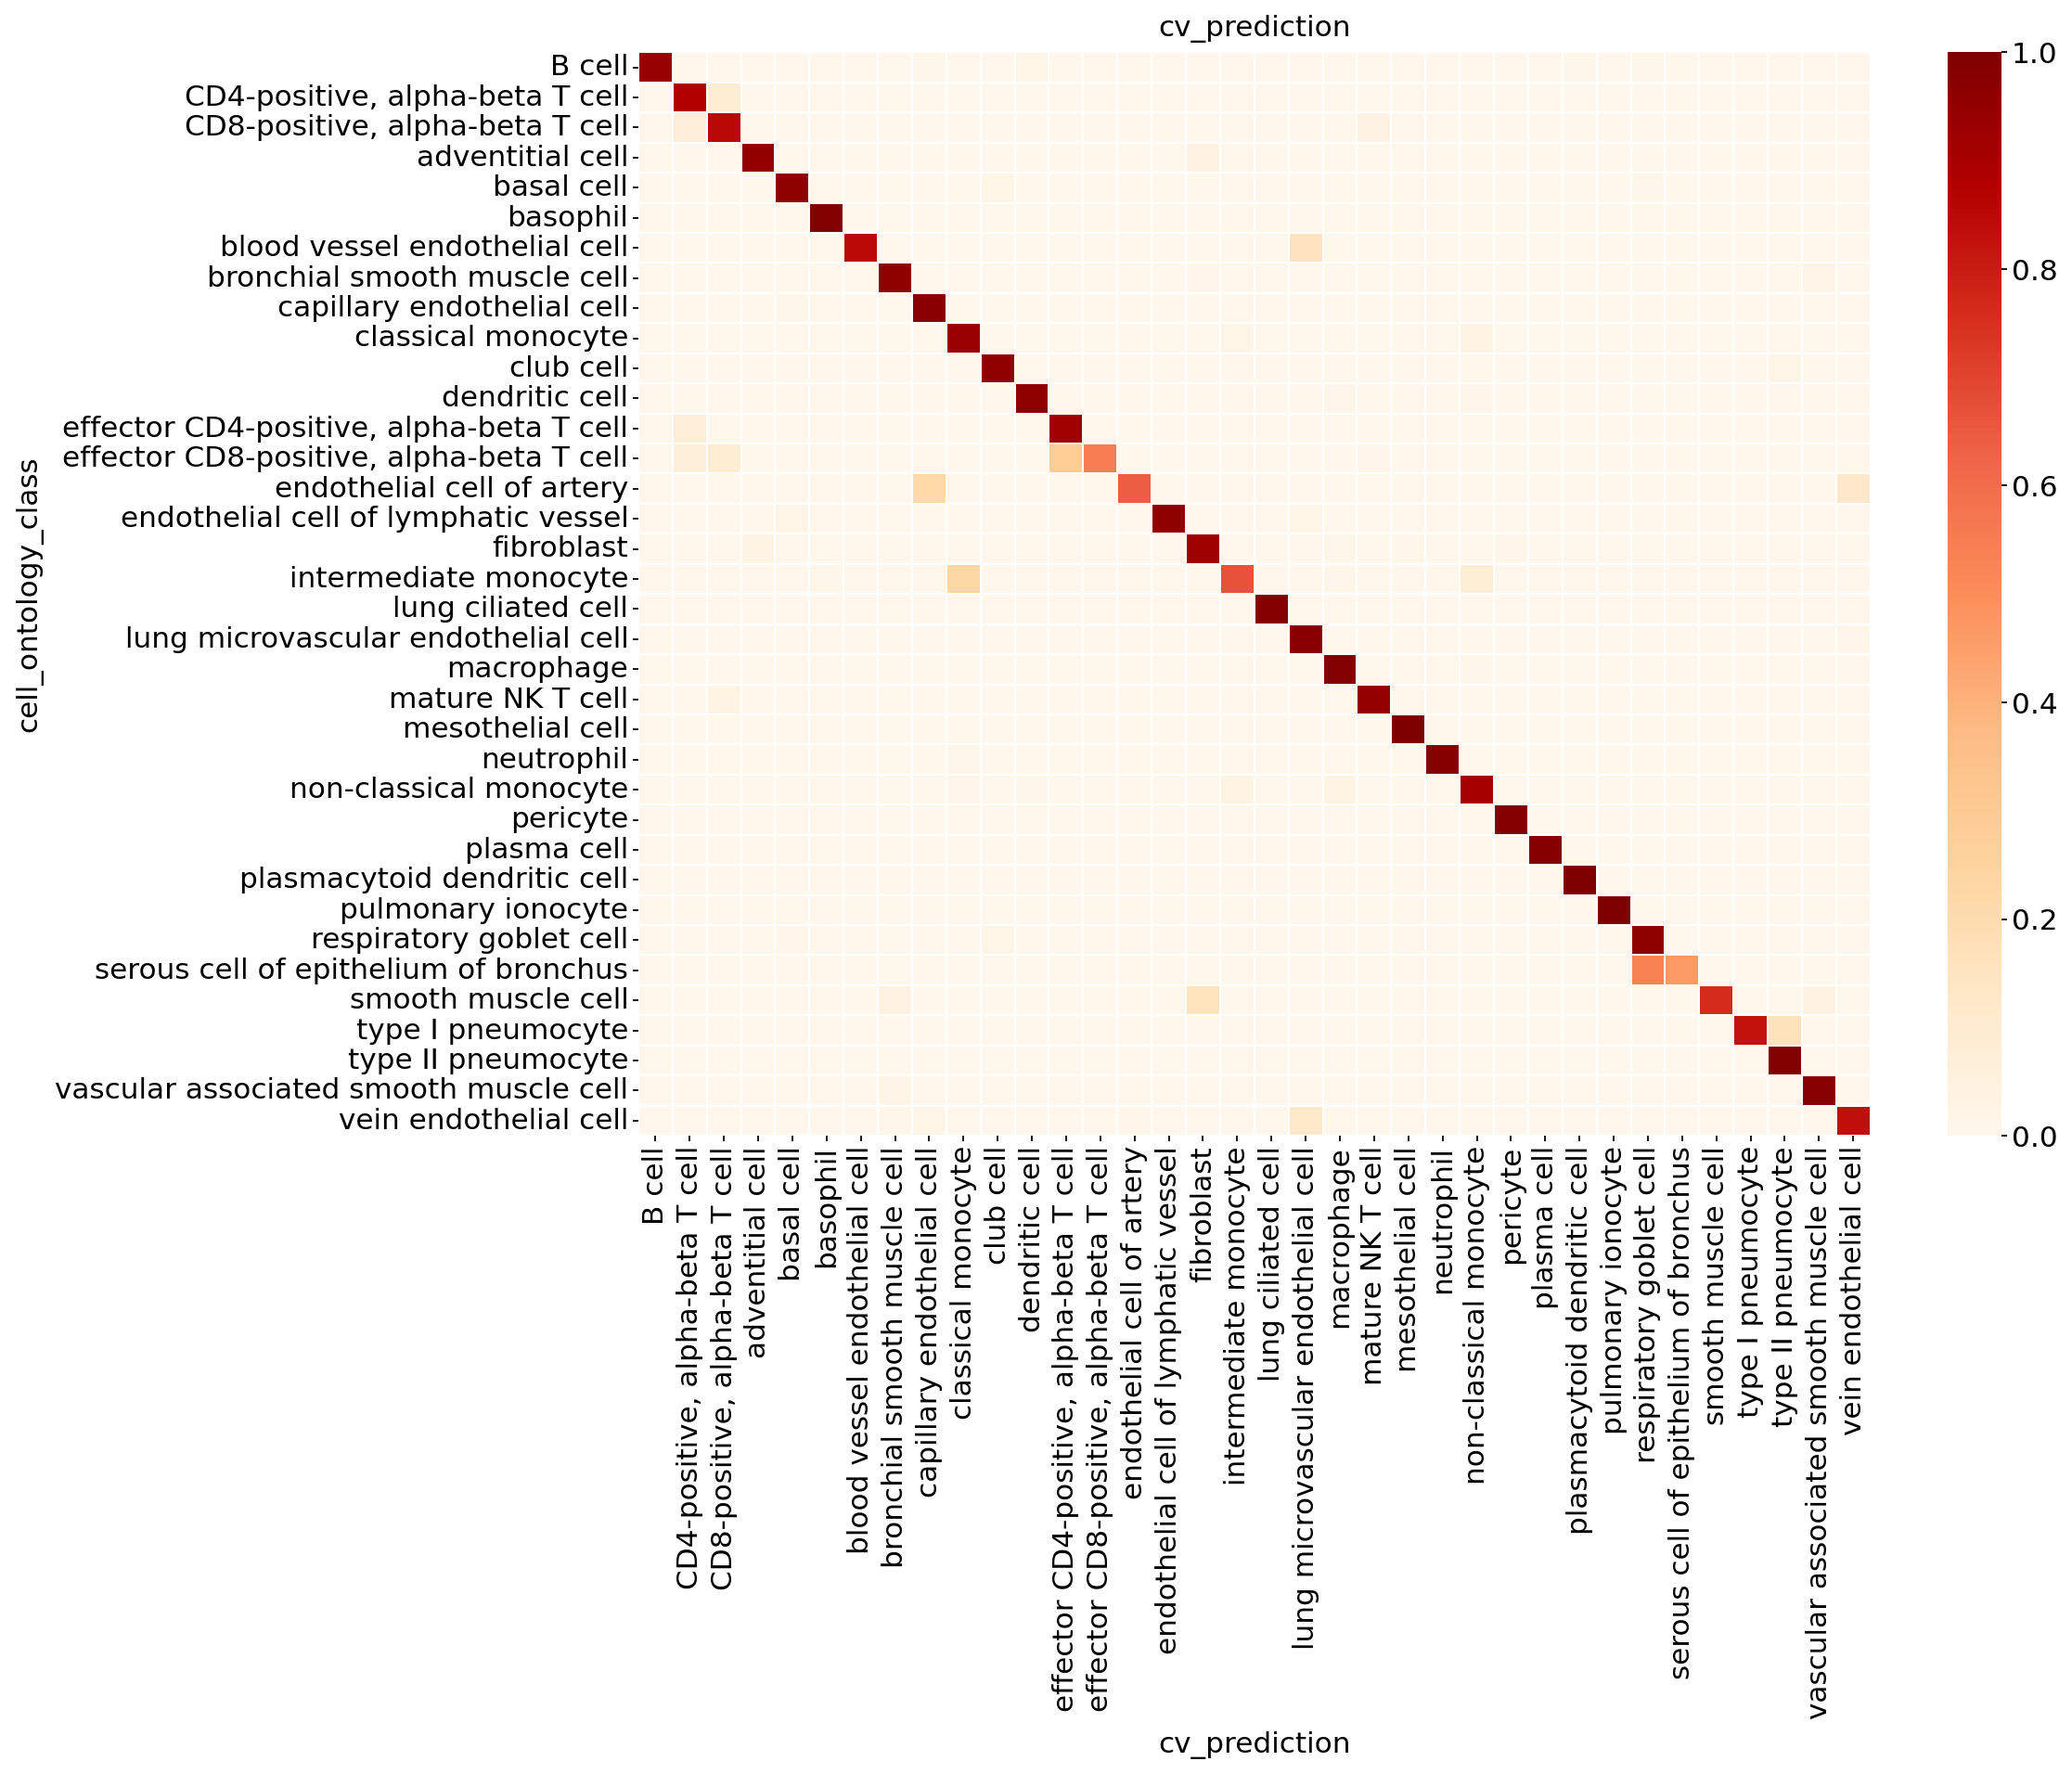

In [14]:
popv.visualization.make_agreement_plots(lung, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [3]:
lung = sc.read('data/Lung_cv_results.h5ad')

In [4]:
lung

AnnData object with n_obs × n_vars = 35672 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'cv_idx'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [5]:
predictors = [i for i in lung.obs.columns if 'popv' in i]

In [6]:
predictors

['popv_celltypist_prediction',
 'popv_knn_on_bbknn_prediction',
 'popv_knn_on_scanorama_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_rf_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction']

Making confusion matrix for popv_celltypist_prediction


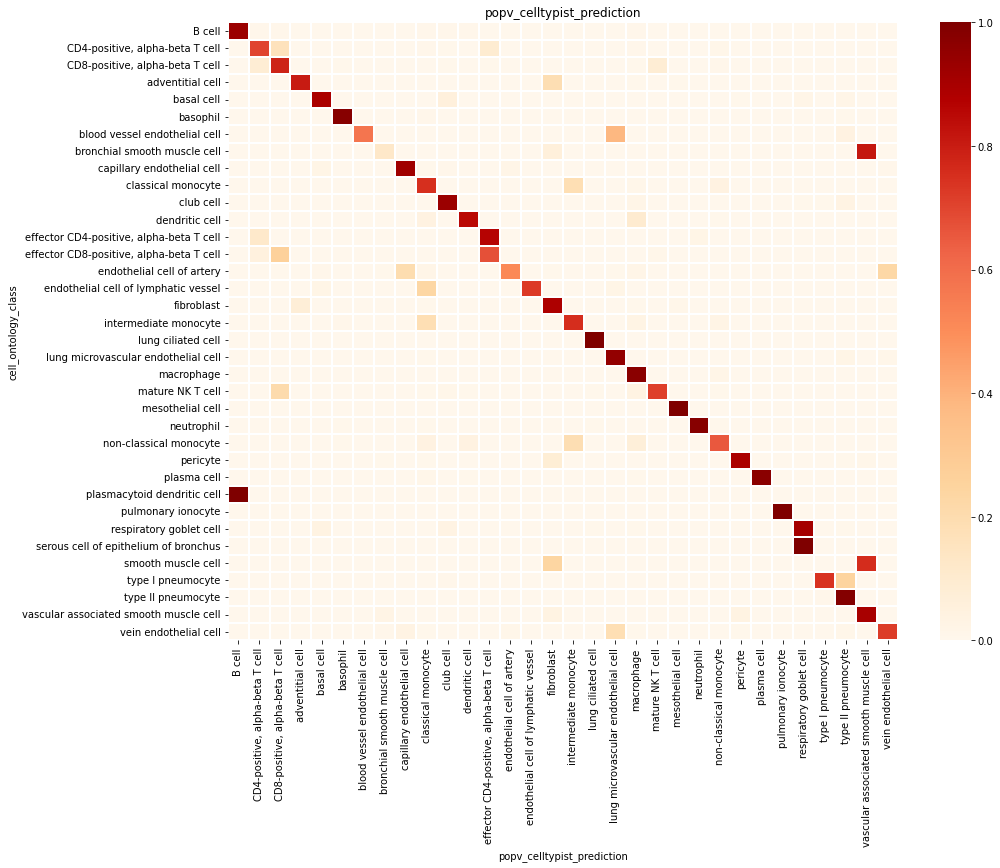

Making confusion matrix for popv_knn_on_bbknn_prediction


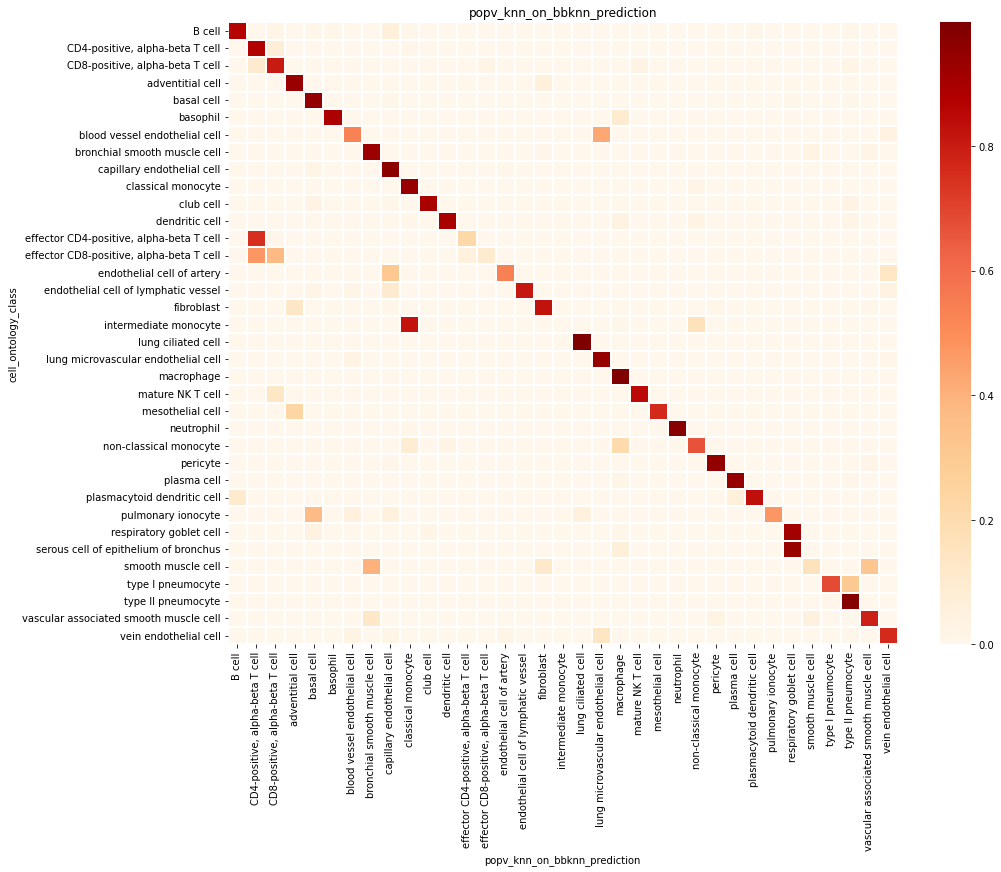

Making confusion matrix for popv_knn_on_scanorama_prediction


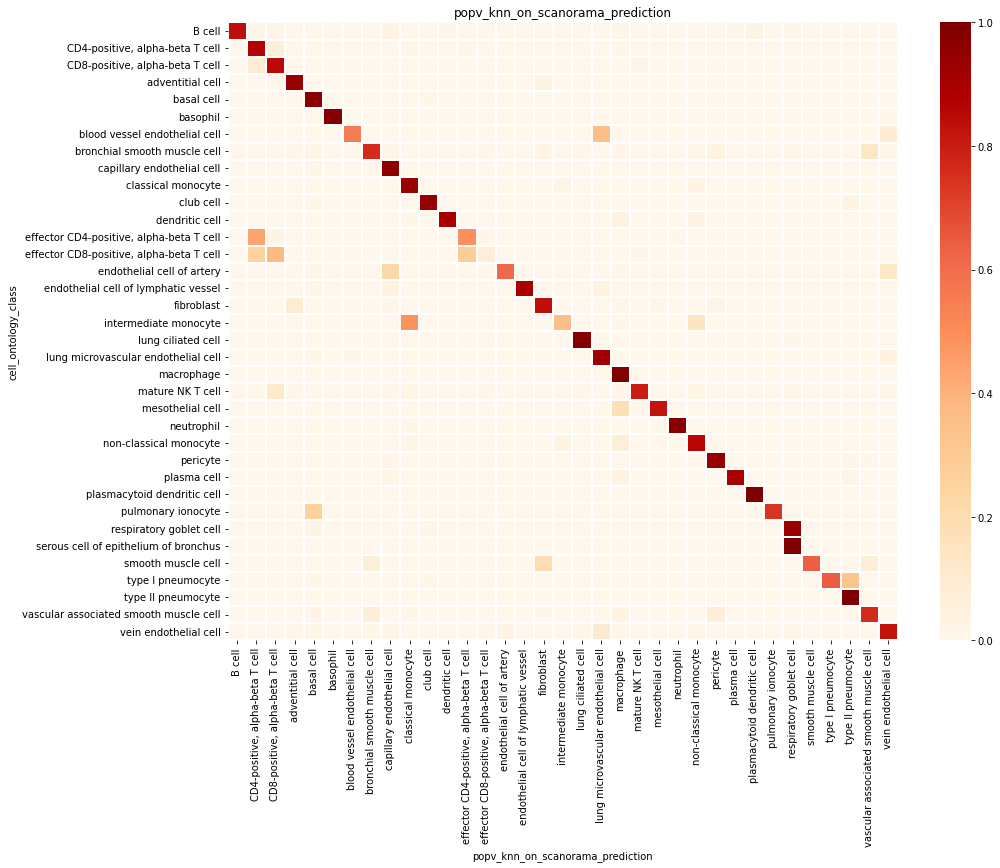

Making confusion matrix for popv_knn_on_scvi_prediction


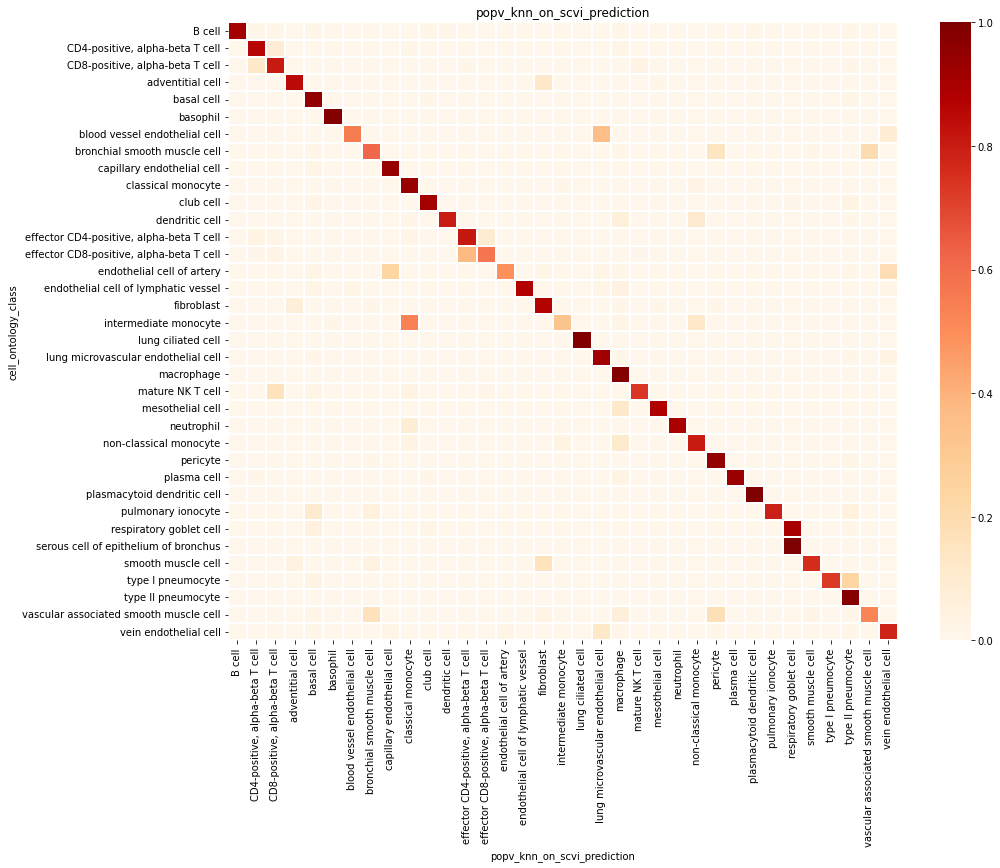

Making confusion matrix for popv_onclass_prediction


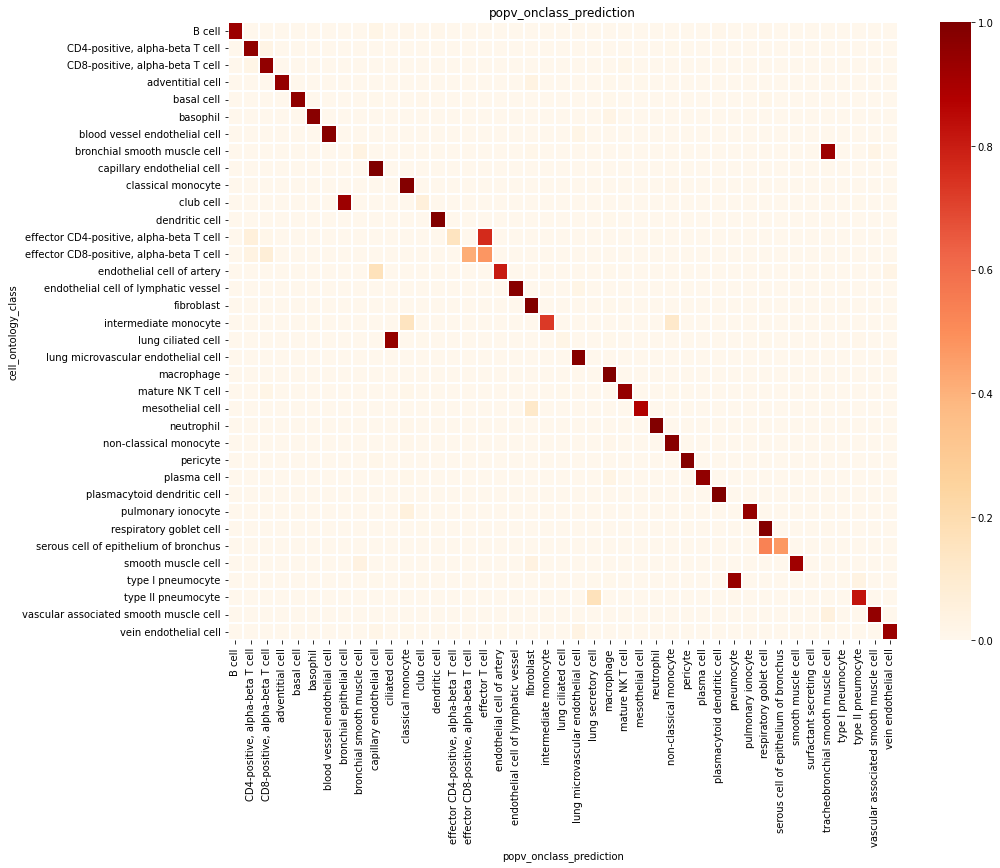

Making confusion matrix for popv_rf_prediction


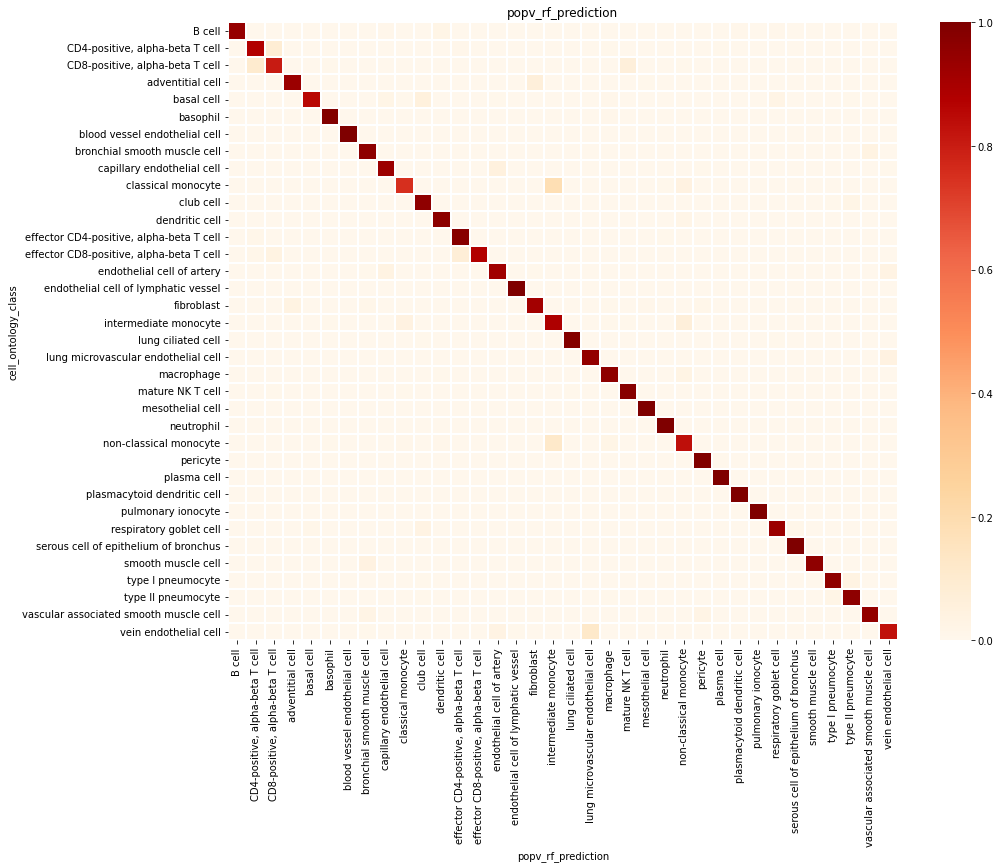

Making confusion matrix for popv_scanvi_prediction


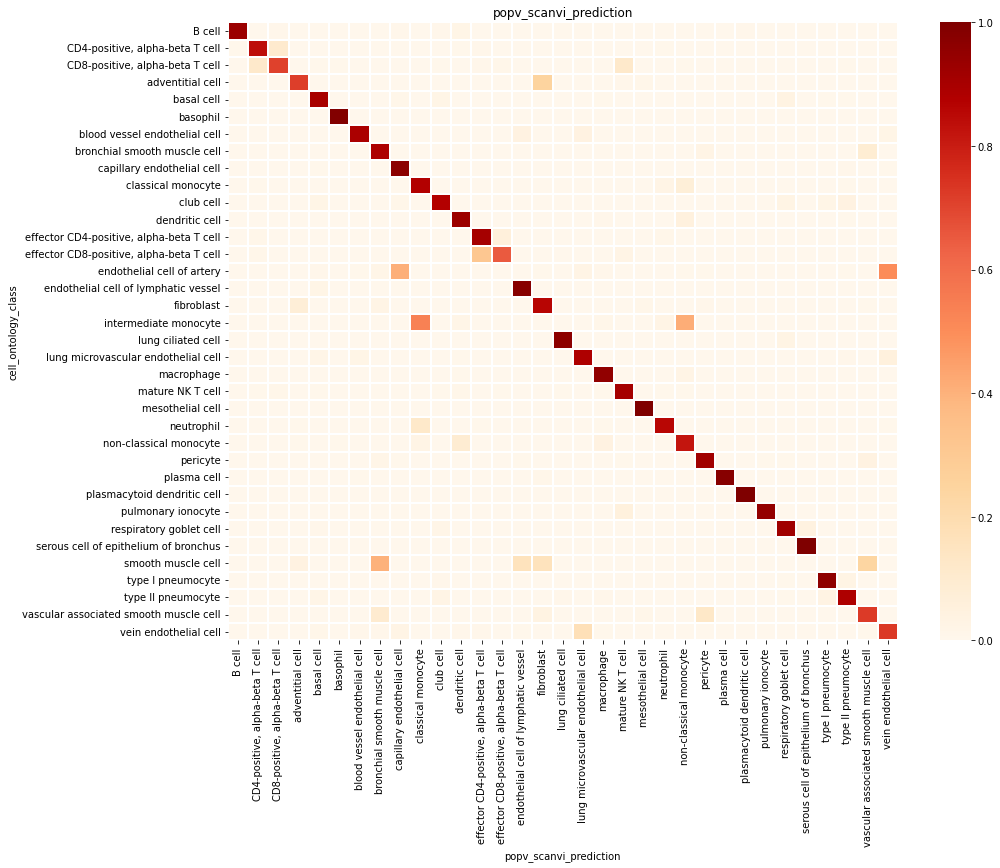

Making confusion matrix for popv_svm_prediction


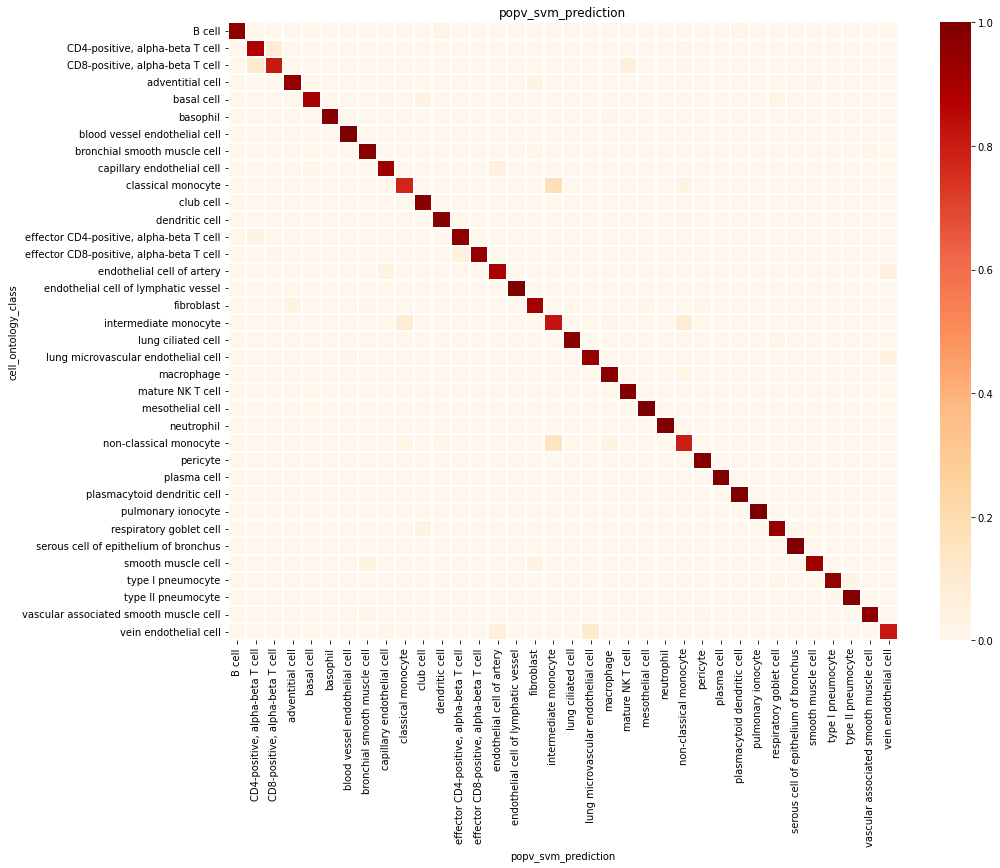

In [7]:
popv.visualization.make_agreement_plots(lung, prediction_keys=predictors, popv_prediction_key='cell_ontology_class', save_folder='.')

In [15]:
lung.write('data/Lung_cv_results.h5ad')

... storing 'cv_prediction' as categorical
... storing 'popv_celltypist_prediction' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction' as categorical
... storing 'popv_svm_prediction' as categorical
... storing 'cv_idx' as categorical


## Weight matrix

In [16]:
from popv.reproducibility import _accuracy
import pandas as pd

In [17]:
lung = sc.read('data/Lung_cv_results.h5ad')

In [18]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']

In [19]:
for key in pred_keys:
    _accuracy._absolute_accuracy(lung, key, 'cell_ontology_class', save_key=key + '_abs_accuracy' )

In [20]:
lung

AnnData object with n_obs × n_vars = 35672 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'cv_idx', 'popv_celltypist_prediction_abs_accuracy', 'popv_knn_on_bbknn_prediction_abs_accuracy', 'popv_knn_on_scanorama_prediction_abs_accuracy', 'popv_knn_on_scvi_prediction_abs_accuracy', 'popv_onclass_prediction_abs_accuracy', 'popv_rf_prediction_abs_accuracy', 'popv_scanvi_prediction_abs_accuracy', 'popv_svm_prediction_abs_accuracy'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std',

In [21]:
pred_acc_keys = [k + "_abs_accuracy" for k in pred_keys]

In [22]:
weight_matrix = pd.DataFrame(index=np.unique(lung.obs[pred_keys]))

In [23]:
for pred_key, acc_key in zip(pred_keys, pred_acc_keys):
    weight_matrix[pred_key] = lung.obs.groupby(pred_key).mean()[acc_key]

In [24]:
weight_matrix.head()

,popv_celltypist_prediction,popv_knn_on_bbknn_prediction,popv_knn_on_scanorama_prediction,popv_knn_on_scvi_prediction,popv_onclass_prediction,popv_rf_prediction,popv_scanvi_prediction,popv_svm_prediction
B cell,0.778846,0.974026,0.986486,0.940476,1.000000,0.921348,0.835052,0.943820
"CD4-positive, alpha-beta T cell",0.852349,0.705357,0.782537,0.852459,0.955963,0.883117,0.843866,0.870438
"CD8-positive, alpha-beta T cell",0.756993,0.806569,0.837790,0.856867,0.953069,0.891348,0.841202,0.894949
adventitial cell,0.920000,0.857494,0.916449,0.929619,1.000000,0.966574,0.806647,0.961853
basal cell,0.963565,0.946813,0.954586,0.919505,0.998569,0.990981,0.902797,0.978164


In [25]:
weight_matrix = weight_matrix.replace(np.nan, 0)
weight_matrix = weight_matrix.replace(0, 1/len(np.unique(lung.obs[pred_keys])))

In [26]:
2

2

In [27]:
weight_matrix.to_csv('lung_weights.csv')

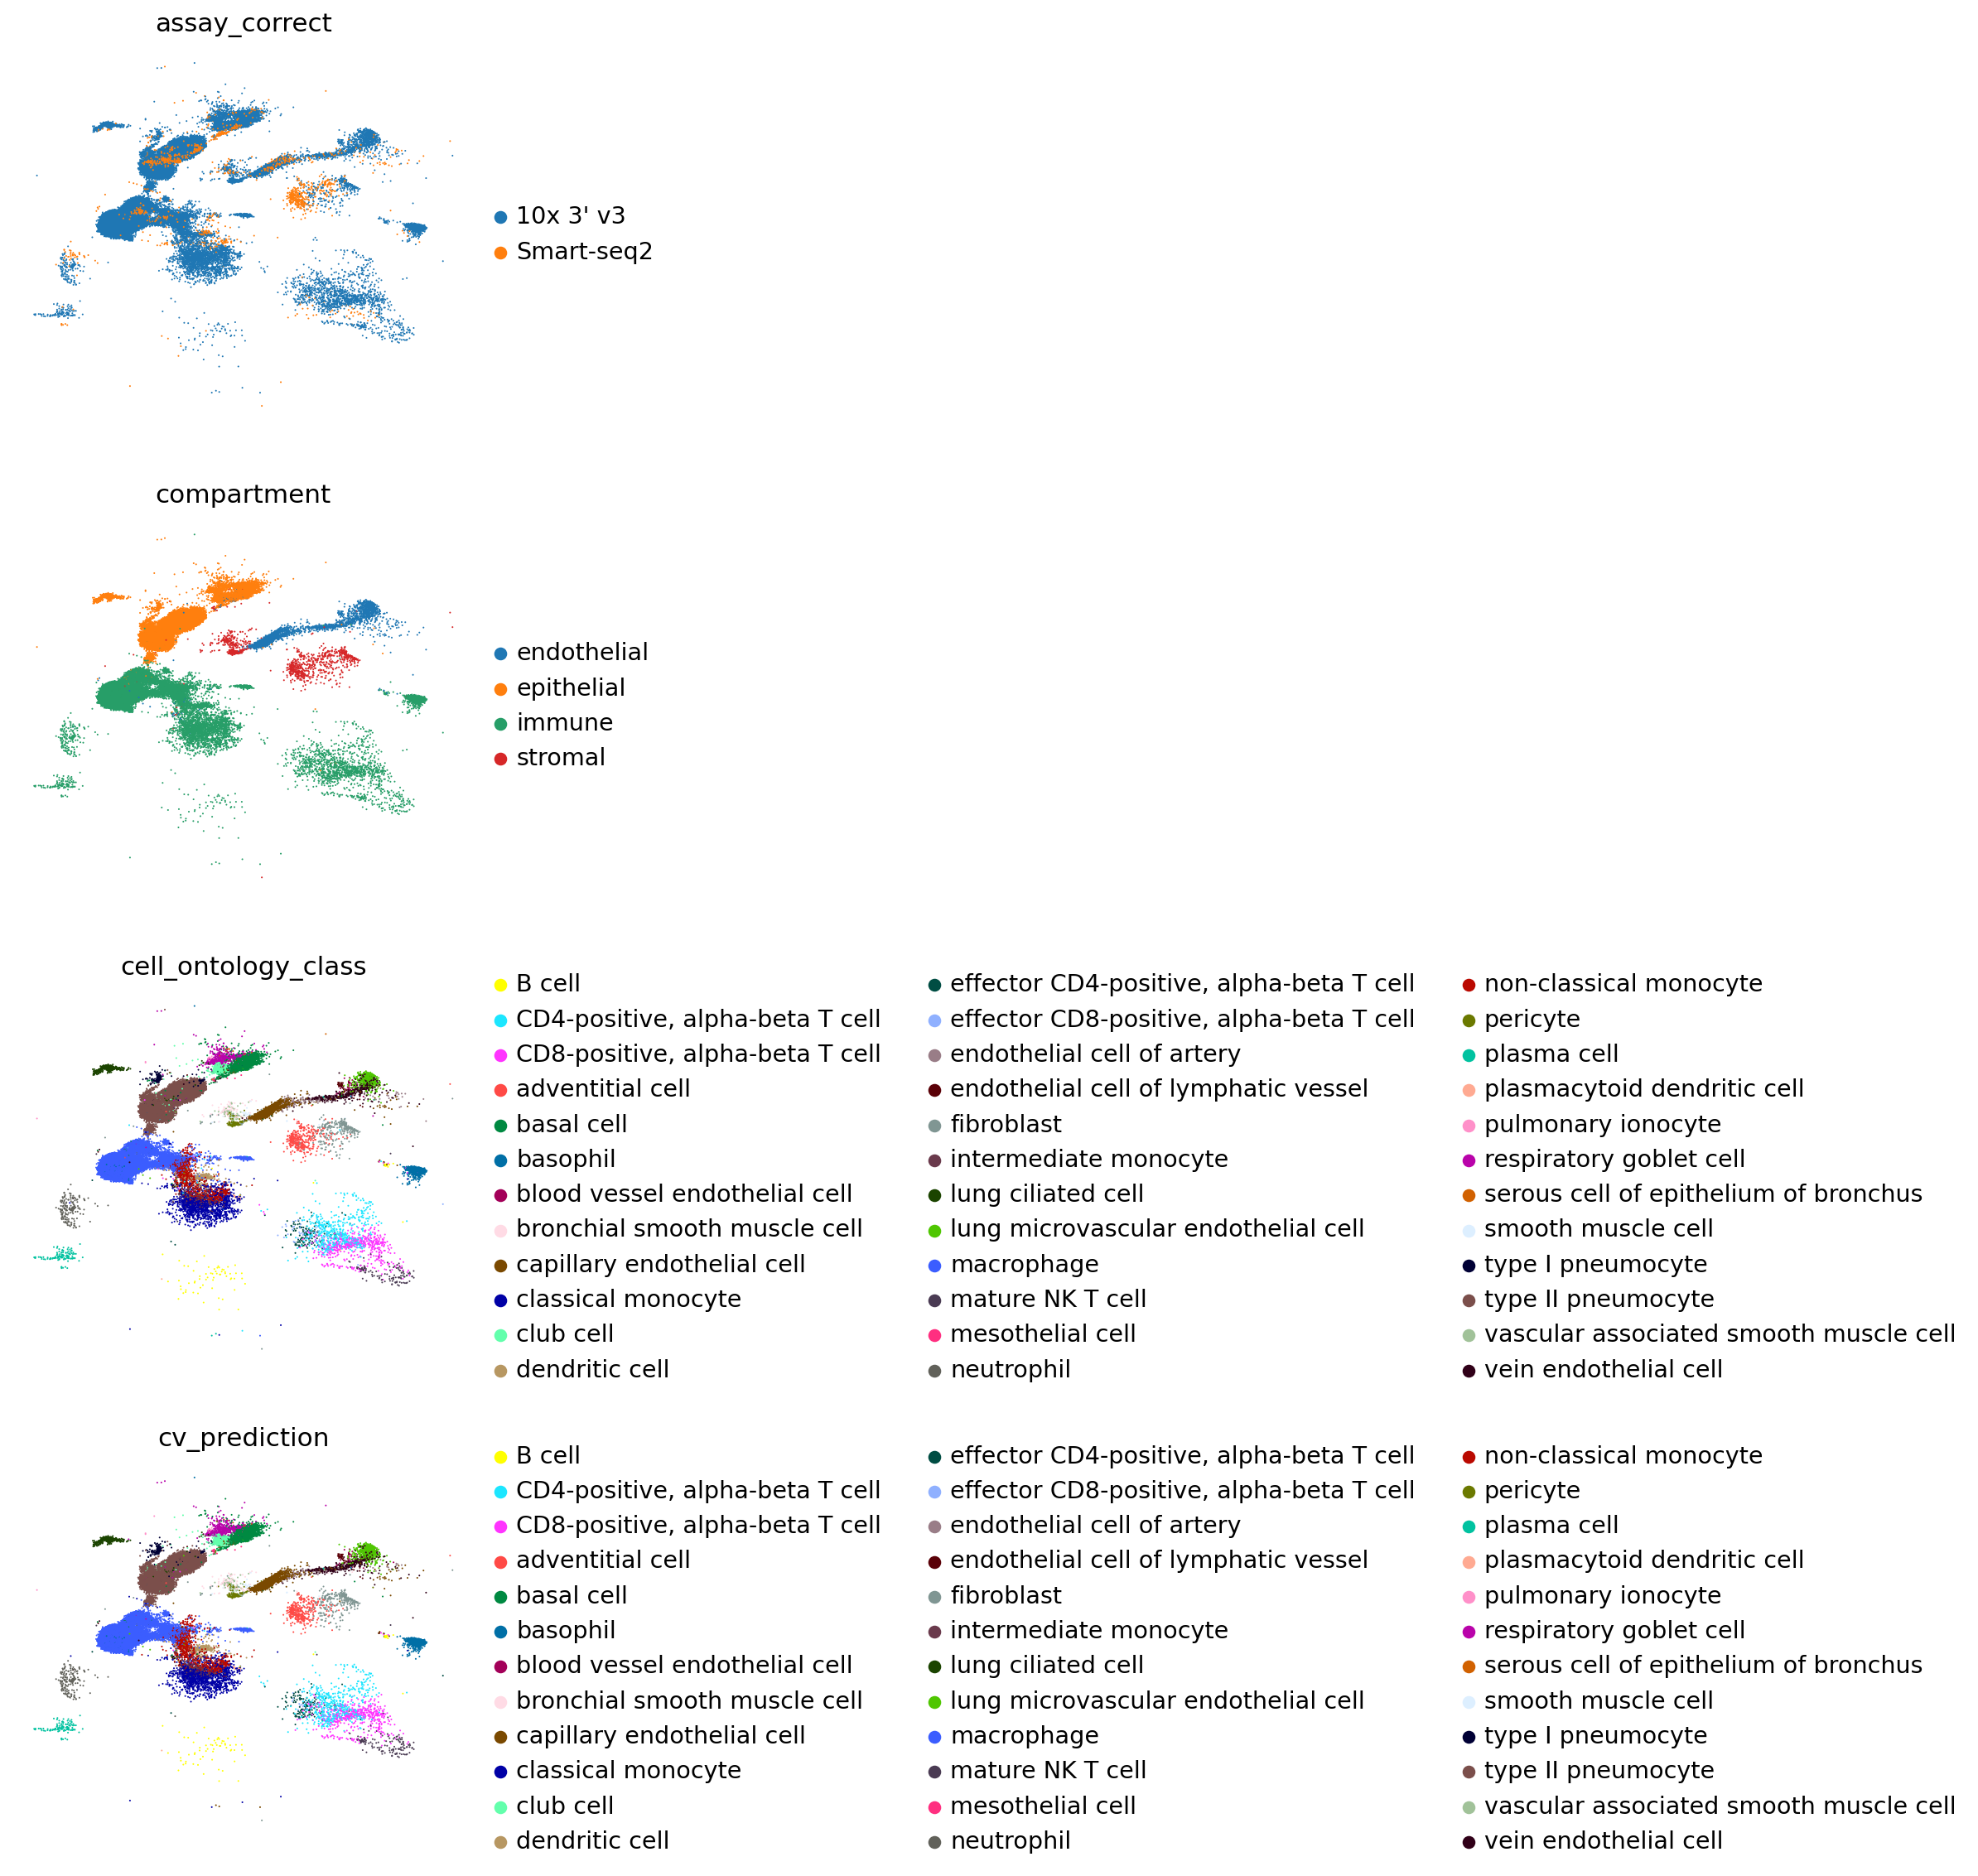

In [28]:
sc.pl.umap(lung, color=['assay_correct', 'compartment', 'cell_ontology_class', 'cv_prediction'], ncols=1, frameon=False)